# Model Comparison: in sample measures

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Generating a data set

We'll generate a minimal noise data set, from a quadratic model, and we'll then try and fit this model with polynomials of different degrees. The idea is to see what polynomial order is from different model comparison measures.

In [44]:
x = np.random.uniform(size=40)
mu = 15 - 4*x + 3*x**2
sigma=0.2
y = np.random.normal(mu,sigma)

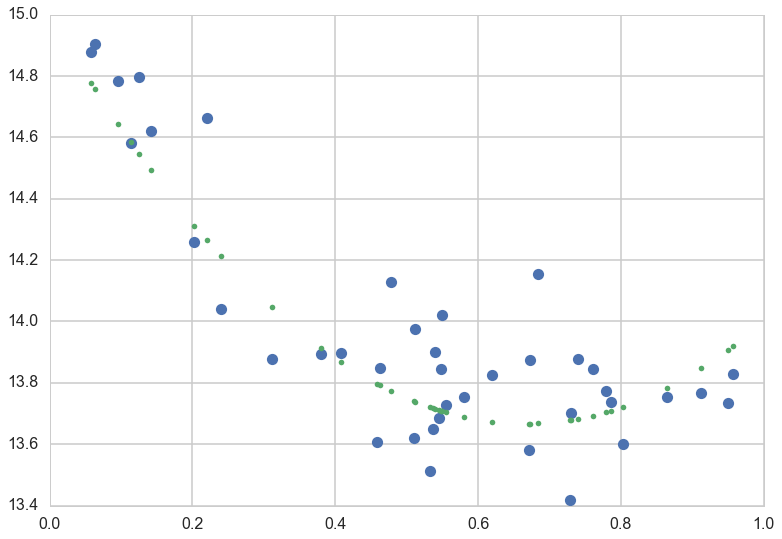

In [45]:
plt.plot(x,y,'o')
plt.plot(x,mu,'.')

### Train-test split

We create a 50-50 train test split. We'd like to keep aside a test set so that we can see how quantities behave on this set.

In [46]:
from sklearn.cross_validation import train_test_split

In [47]:
itrain, itest = train_test_split(range(40), train_size=20)

We'll center the data

In [48]:
x = x - x.mean()

In [49]:
xtrain=x[itrain]
ytrain=y[itrain]
xtest=x[itest]
ytest=y[itest]

In [59]:
ridge = 3

We'll use `scikit-learn` to construct polynomial features:

In [60]:
from sklearn.preprocessing import PolynomialFeatures
import theano.tensor as T

As an example, we'll sample a quintic model.

In [61]:
msize=2
pf=PolynomialFeatures(msize, include_bias=False).fit_transform(xtrain.reshape(-1,1))
print(pf.shape)
with pm.Model() as m:
    alpha = pm.Normal('alpha', 0, 100)
    beta = pm.Normal('beta', mu=0, sd=ridge, shape=msize)
    mu = alpha + pm.math.dot(pf, beta)
    o = pm.Normal('o', mu, sigma, observed=ytrain)
    trace=pm.sample(5000, init='MAP')
                       

(20, 2)
Optimization terminated successfully.
         Current function value: 1.698554
         Iterations: 3
         Function evaluations: 7
         Gradient evaluations: 7


100%|██████████| 5000/5000 [00:10<00:00, 459.60it/s]   | 15/5000 [00:00<00:34, 143.39it/s]


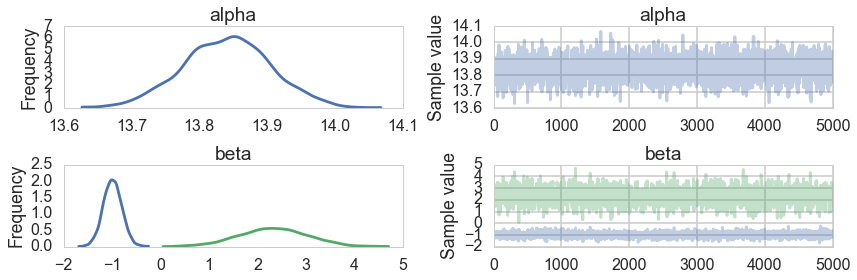

In [62]:
pm.traceplot(trace);

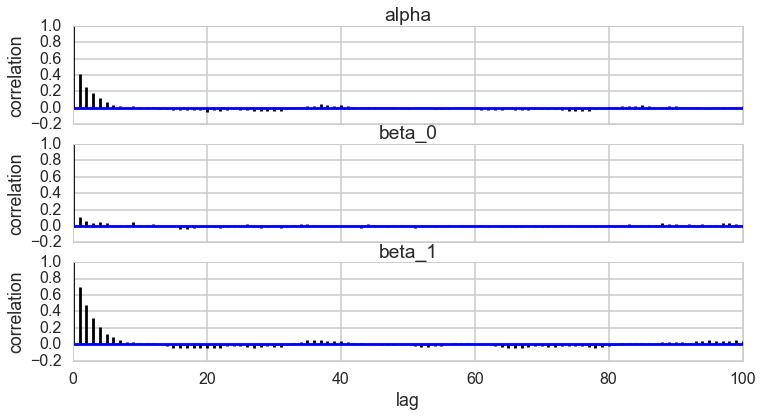

In [63]:
pm.autocorrplot(trace);

## Calculating likelihoods

In `pymc3`, the `logp` method of a node, which takes a dictionary of trace values of a node's parents as arguments, gives us the conditional (log) probability of the node given its parents. Thus the conditional probability of the observed node, which is also the model node, gives us $p ( y \vert etc)$, of the likelihood of the data $y$. If we wish to evaluate this likelihood for a test set with its new data, we must then create a new model for it. We WONT sample from it, since that would be just another training set. But we'll use posterior MAP or mean values of the parameters with the new model's `logp` to compute $p(y_{test} \vert \theta_{train})$

In [64]:
pftest=PolynomialFeatures(msize, include_bias=False).fit_transform(xtest.reshape(-1,1))
with pm.Model() as mtest:
    alpha = pm.Normal('alpha', 0, 100)
    beta = pm.Normal('beta', mu=0, sd=ridge, shape=msize)
    mu = alpha + pm.math.dot(pftest, beta)
    o = pm.Normal('o', mu, sigma, observed=ytest)                       

Here we calculate the mean, and then use it to calculate the log-lkelihood of the data given the parameter mean.

In [65]:
meanpoint={'alpha': trace['alpha'].mean(), 'beta': trace['beta'].mean(0)}
meanpoint

{'alpha': 13.840500632702547, 'beta': array([-0.99418043,  2.31483997])}

In [66]:
m.logp(meanpoint), mtest.logp(meanpoint)

(array(-1.699085634529018), array(-5.251454815218393))

## Simulating an ensemble of models

Now imagine we dont know what generated the data and go to find out:

In [67]:
models20={}

for msize in [1,2,3,4, 5,10, 15, 19]:
    pf=PolynomialFeatures(msize, include_bias=False).fit_transform(xtrain.reshape(-1,1))
    pftest=PolynomialFeatures(msize, include_bias=False).fit_transform(xtest.reshape(-1,1))

    with pm.Model() as m:
        alpha = pm.Normal('alpha', 0, 100)
        beta = pm.Normal('beta', mu=0, sd=ridge, shape=msize)
        mu = alpha + pm.math.dot(pf, beta)
        o = pm.Normal('o', mu, sigma, observed=ytrain)
        trace=pm.sample(5000, init='MAP')
        
    with pm.Model() as mtest:
        alpha = pm.Normal('alpha', 0, 100)
        beta = pm.Normal('beta', mu=0, sd=ridge, shape=msize)
        mu = alpha + pm.math.dot(pftest, beta)
        o = pm.Normal('o', mu, sigma, observed=ytrain)
                           
    models20[msize] = (m, trace, mtest)

Optimization terminated successfully.
         Current function value: 5.382064
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5


100%|██████████| 5000/5000 [00:07<00:00, 672.18it/s]   | 35/5000 [00:00<00:14, 339.27it/s]


Optimization terminated successfully.
         Current function value: 1.698554
         Iterations: 3
         Function evaluations: 7
         Gradient evaluations: 7


100%|██████████| 5000/5000 [00:09<00:00, 517.09it/s]   | 27/5000 [00:00<00:19, 259.27it/s]


Optimization terminated successfully.
         Current function value: 3.132637
         Iterations: 6
         Function evaluations: 10
         Gradient evaluations: 10


100%|██████████| 5000/5000 [01:08<00:00, 72.72it/s]    | 4/5000 [00:00<02:36, 31.92it/s]


Optimization terminated successfully.
         Current function value: 5.137939
         Iterations: 10
         Function evaluations: 14
         Gradient evaluations: 14


100%|██████████| 5000/5000 [02:24<00:00, 21.34it/s]    | 4/5000 [00:00<02:07, 39.05it/s]


Optimization terminated successfully.
         Current function value: 7.143593
         Iterations: 13
         Function evaluations: 17
         Gradient evaluations: 17


100%|██████████| 5000/5000 [03:37<00:00, 22.99it/s]    | 4/5000 [00:00<02:48, 29.59it/s]


Optimization terminated successfully.
         Current function value: 17.230315
         Iterations: 13
         Function evaluations: 17
         Gradient evaluations: 17


100%|██████████| 5000/5000 [05:08<00:00, 16.20it/s]    | 4/5000 [00:00<02:21, 35.35it/s]


Optimization terminated successfully.
         Current function value: 27.318068
         Iterations: 13
         Function evaluations: 17
         Gradient evaluations: 17


100%|██████████| 5000/5000 [05:06<00:00, 16.29it/s]    | 4/5000 [00:00<02:43, 30.62it/s]


Optimization terminated successfully.
         Current function value: 35.388272
         Iterations: 13
         Function evaluations: 17
         Gradient evaluations: 17


100%|██████████| 5000/5000 [05:10<00:00, 10.87it/s]    | 4/5000 [00:00<02:18, 36.12it/s]


We have produced an ensemble of 6 models with traces and both training and testing models which we can now use.

In [68]:
models20

{1: (<pymc3.model.Model at 0x12b1a74e0>,
  <MultiTrace: 1 chains, 5000 iterations, 2 variables>,
  <pymc3.model.Model at 0x12f2b1208>),
 2: (<pymc3.model.Model at 0x12ff28400>,
  <MultiTrace: 1 chains, 5000 iterations, 2 variables>,
  <pymc3.model.Model at 0x12dc97fd0>),
 3: (<pymc3.model.Model at 0x12dab33c8>,
  <MultiTrace: 1 chains, 5000 iterations, 2 variables>,
  <pymc3.model.Model at 0x13086ccc0>),
 4: (<pymc3.model.Model at 0x130ebc828>,
  <MultiTrace: 1 chains, 5000 iterations, 2 variables>,
  <pymc3.model.Model at 0x12c942358>),
 5: (<pymc3.model.Model at 0x12efecd68>,
  <MultiTrace: 1 chains, 5000 iterations, 2 variables>,
  <pymc3.model.Model at 0x13184f630>),
 10: (<pymc3.model.Model at 0x131eb30b8>,
  <MultiTrace: 1 chains, 5000 iterations, 2 variables>,
  <pymc3.model.Model at 0x12fb60e80>),
 15: (<pymc3.model.Model at 0x1309ae160>,
  <MultiTrace: 1 chains, 5000 iterations, 2 variables>,
  <pymc3.model.Model at 0x13294c278>),
 19: (<pymc3.model.Model at 0x132d303c8>,
  <M

## Information Criteria

All information criteria derive from the **Deviance**, which we learnt about when we learned about the KL-divergence. Here is a short summary.

If $p$ is nature's distribution, we want to know how far we are from "perfect accuracy" by using $q$. In other words we need to develop a distance scale for distances between distributions.

This scale is called the Kullback-Leibler (KL) Divergence, introduced in 1951. It is defined thus:

$$\renewcommand{\kld}{D_{KL}}$$

$$\kld(p, q) = E_p[log(p) - log(q)] = E_p[log(p/q)] = \sum_i p_i log(\frac{p_i}{q_i}) \,\,or\, \int dP log(\frac{p}{q})$$

The distance between a distribution and itself is clearly $\kld(p,p) = 0$.

We can use Jensen's inequality for expectations on a convex function $f(x)$,

$$ E[f(X)] \ge f(E[X]) $$

to show that $\kld(p,q) \ge 0$ with equality iff (if and only if) $q=p$.

If one uses the **law or large numbers** to replace the true distribution by its empirical estimate, then we have:

$$\kld(p, q) = E_p[log(p/q)] = \frac{1}{N}\sum_i (log(p_i) - log(q_i)$$

Thus minimizing the KL-divergence involves maximizing $\sum_i log(q_i)$ which is exactly the log likelihood. Hence we can justify the maximum likelihood principle.

### Comparing models

By the same token we can use the KL-Divergences of two different models to do model comparison:

$$\kld(p, q) -\kld(p, r) = E_p[log(r) - log(q)] = E_p[log(\frac{r}{q})]$$

Notice that except for choosing the empirical samples, $p$ has dissapeared from this formula.

f you look at the expression above, you notice that to compare a model with distribution $r$ to one with distribution $q$, you only need the sample averages of the logarithm of $r$ and $q$:

$$\kld(p, q) -\kld(p, r) = \langle log(r) \rangle - \langle log(q) \rangle$$

where the angled brackets mean sample average. If we define the deviance:

$$D(q) = -2 \sum_i log(q_i)$$,

then

$$\kld(p, q) -\kld(p, r) = \frac{2}{N} (D(q) - D(r))$$

so that we can use the deviance's for model comparison instead.

More generally, we can define the deviance without using the sample average over the empirical distribution as

$$ D(q) = - \frac{N}{2} E_p[log(q)] $$

Now in the frequentist realm one used likelihoods. In the bayesian realm, the **posterior predictive**, which has learned from the data seems to be the more sensible distribution to use. But lets work our way there.

In other words, we are trying to estimate $E_p[log(pp(y))]$ where $pp(y)$ is the posterior predictive for points $y$ on the test set or future data.

We replace this joint posterior predictive over new points $y$ by product of marginals and thus a sum of log-marginals at new points(since we are doing logs). 

$$\sum_i E_p[log(pp(y_i))]$$

The quantity inside the sum is called the elpd (expected log predictive density) and the entire thing the elppd (expected log pointwise predictive density. Clearly the product of marginals is not the joint, so this is a different quantity, crafted to give us a pointwise notion of deviance.

## Information Measures

We now look at a series of information measures, with greater and greater bayesianism in them. Each of these makes more and more sophisticated estimates of the Deviance. We wish to estimate the **out-of-sample** deviance, but unless we resort to cross-validation and do repeated fitting, we would be better off estimating the in-sample deviance and doing something to it.

### The AIC

In the image below

![](images/devianceaic.png)

The test set deviances are $2*p$ above the training set ones, approximately, where $p$ is the number of parameters in the model.

This observation leads to an estimate of the out-of-sample deviance by what is called an **information criterion**, the Akake Information Criterion, or AIC:

$$AIC = D_{train} + 2p$$


$$D_{train} = -2*log(p( y \vert \theta_{mle})$$

and which does carry as an assumption the notion that the likelihood is approximately multivariate gaussian, which as we have seen will be true near its peak.

This is just a penalized log-likelihood or risk if we choose to identify our distribution with the likelihood, and at higher numbers of parameters, increases the out-of-sample deviance, making them less desirable. In a sense, this penalization is a simple form of regularization on our model.

You can think of it as a **bias** correction, the bias arising because we use our data twice: once to fit the model, and secondly to estimate the Deviance (or KL-divergence).

AIC is reliable only in the case of flat priors overwhelmed by likelihood, an approximately gaussian multivariate posterior, and a sample size much greater thasn the number of parameters.
The AIC is not a bayesian measure and we wont bother more about it here.

### The DIC (Deviance Information Criterion)

The DIC still uses point estimation, but does so using the posterior distribution. It replaces the MLE with the posterior mean and calculates a similar point estimate. And then it uses the posterior distribution of the training deviance.

Like AIC, the DIC assumes a multivariate gaussian posterior distribution.

$$D_{train} = -2*log(p( y \vert \theta_{post mean})$$

Then DIC, estimating the out-of-sample deviance is

$$DIC = D_{train} + 2p_D$$ where $p_D$ is an effective number of parameters and is calculated thus:

$$p_{DIC} = 2*\left(log(p(y \vert \theta_{post mean}) - E_{post}[log(p(y \vert \theta)]\right)$$

The expectation in the second term is taken over the posterior. It might look like the posterior predictive to you, but remember, we are *not drawing* new y here, but rather computing expectations over existing y. Indeed we are integrating over the deviance, not the likelihood. So this is a true-blue monte carlo average!

We have implemented the definition below, but it is also defined for you in `pymc`.

In [69]:
def mean_deviance(trace, model):
    logps=np.empty(len(trace))
    for i, ele in enumerate(trace):
        logps[i]=model.logp(ele)
    return -2*np.mean(logps)
def deviance_at_mean(trace, model):
    dam =  -2*model.logp(dict(alpha=np.mean(trace['alpha']), beta=np.mean(trace['beta'], axis=0)))
    return dam

In [70]:
tt=models20[5][1]
mm=models20[5][0]
2*mean_deviance(tt, mm) - deviance_at_mean(tt, mm), pm.dic(tt, mm)

(26.998659736095728, 26.998659736095728)

An alternative fomulation for $p_D$, guaranteed to be positive, is

$$p_D = 2 * Var_{post}[log(p(y \vert \theta_{post mean}))]$$

In [73]:
for npa in models20:
    m,t, test=models20[npa]
    print("For Model with {} slope, dic is {}".format(npa, pm.dic(t, model=m)))

For Model with 19 slope, dic is 114.8922879773209
For Model with 1 slope, dic is 14.754881277586044
For Model with 2 slope, dic is 9.315532339708351
For Model with 3 slope, dic is 14.429626596917327
For Model with 4 slope, dic is 23.634453163719378
For Model with 5 slope, dic is 26.99865973609573
For Model with 10 slope, dic is 60.436331238741445
For Model with 15 slope, dic is 92.68228005183747


### The WAIC

This is finally, a fully bayesian construct.

It does not require a multivariate gaussian posterior. The distinguishing feature of it is that its pointwise, it does not use the joint $p(y)$ to make its estimates. This is very useful for glms by fitting for each observation, then summing up over observations.

Since we do not know the true distribution $p$, we replace the Deviance term 

$$\sum_i E_p[log(pp(y_i))]$$

where $y_i$ are new
 
by the computed "log pointwise predictive density" (lppd) **in-sample**

$$\sum_j log\left<p(y_j \vert \theta)\right> = \sum_j log\left(\frac{1}{S}\sum_s p(y_j \vert \theta_s) \right)$$

which now does the full monte-carlo average in the angled brackets on a point-wise basis.

The lppd is the total across in-sample observations of the average likelihood (over the posterior of each observation. Multiplied by -2, its the pointwise analog of deviance.

The $p_W$ correction also becomes more fully bayesian, as in being

$$p_W = 2\sum_i \left(log(E_{post}[p(y_i \vert \theta)] - E_{post}[log(p(y_i \vert \theta))] \right)$$

Once again this can be estimated by
$$\sum_i Var_{post}[log(p(y_i \vert \theta))]$$

If you do these calculations by hand (and you should to check) make sure you use the `log-sum-exp` trick. Start with log(p), exponential it, sum it, and log again.

Now

$$WAIC = lppd +2 p_W$$

In [72]:
for npa in models20:
    m,t, test=models20[npa]
    print("For Model with {} slope, waic is {}".format(npa, pm.waic(t, model=m)))

//anaconda/envs/py35/lib/python3.5/site-packages/pymc3/stats.py:145: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


For Model with 19 slope, waic is WAIC_r(WAIC=217.71253577045238, WAIC_se=76.162973636600512, p_WAIC=116.79056518877732)


//anaconda/envs/py35/lib/python3.5/site-packages/pymc3/stats.py:145: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


For Model with 1 slope, waic is WAIC_r(WAIC=0.084262212703441364, WAIC_se=5.7281546738617957, p_WAIC=2.3430178588443322)
For Model with 2 slope, waic is WAIC_r(WAIC=-11.765913940231583, WAIC_se=4.396580055759542, p_WAIC=1.5525004480612663)
For Model with 3 slope, waic is WAIC_r(WAIC=-12.679095197525827, WAIC_se=3.9299331333478302, p_WAIC=1.658188644204907)
For Model with 4 slope, waic is WAIC_r(WAIC=544.85432351349323, WAIC_se=180.42123029604664, p_WAIC=280.39615289525813)
For Model with 5 slope, waic is WAIC_r(WAIC=-8.3916182629893203, WAIC_se=4.0373474714536766, p_WAIC=3.7988898100329083)
For Model with 10 slope, waic is WAIC_r(WAIC=58.012489419928784, WAIC_se=23.062149153091891, p_WAIC=36.917302814238624)
For Model with 15 slope, waic is WAIC_r(WAIC=565.67514263974772, WAIC_se=187.98741377510669, p_WAIC=290.78018239560049)


As we saw earlier in machine learning, many polynomial models will be fine. We next see an example of model-selection in Posson regression which puts the WAIC to good use.

### Using information criteria

I will just quote McElreath:

>But once we have DIC or WAIC calculated for each plausible model, how do we use these values? Since information criteria values provide advice about relative model performance, they can be used in many different ways. Frequently, people discuss MODEL SELECTION, which usually means choosing the model with the lowest AIC/DIC/WAIC value and then discarding the others. But this kind of selection procedure discards the information about relative model accuracy contained in the differences among the AIC/DIC/WAIC values. Why is this information useful? Because sometimes the differences are large and sometimes they are small. Just as relative posterior probability provides advice about how confident we might be about parameters (conditional on the model), relative model accuracy provides advice about how confident we might be about models (conditional on the set of models compared).

>So instead of model selection, this section provides a brief example of model comparison and model averaging.
- MODEL COMPARISON means using DIC/WAIC in combination with the estimates and posterior predictive checks from each model. It is just as important to understand why a model outperforms another as it is to measure the performance difference. DIC/WAIC alone says very little about such details. But in combination with other information, DIC/WAIC is a big help.
- MODEL AVERAGING means using DIC/WAIC to construct a posterior predictive distribution that exploits what we know about relative accuracy of the models. This helps guard against overconfidence in model structure, in the same way that using the entire posterior distribution helps guard against overconfidence in parameter values. What model averaging does not mean is averaging parameter estimates, because parameters in different models have different meanings and should not be averaged, unless you are sure you are in a special case in which it is safe to do so. So it is better to think of model averaging as prediction averaging, because that's what is actually being done. (McElreath 195-196)

